# Pytorch

In [1]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import gc

from torch import nn

## 1 Tensor 基本操作

References:
- [torch.Tensor](https://pytorch.org/docs/stable/tensors.html)
- [PyTorch - Basic operations](https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/)

In [2]:
torch.manual_seed(0)

In [3]:
print(torch.rand(2))

tensor([0.4963, 0.7682])


### 1.1 Create a Tensor

In [4]:
torch.rand(2, 3) # Initialize with random number (uniform distribution)

tensor([[0.0885, 0.1320, 0.3074],
        [0.6341, 0.4901, 0.8964]])

In [5]:
# With normal distribution (SD=1, mean=0)
torch.randn(2, 3) 

tensor([[-1.0845, -1.3986,  0.4033],
        [ 0.8380, -0.7193, -0.4033]])

In [6]:
# 可以用括号指定维度
torch.rand((1, 3, 2, 4))

tensor([[[[0.6816, 0.9152, 0.3971, 0.8742],
          [0.4194, 0.5529, 0.9527, 0.0362]],

         [[0.1852, 0.3734, 0.3051, 0.9320],
          [0.1759, 0.2698, 0.1507, 0.0317]],

         [[0.2081, 0.9298, 0.7231, 0.7423],
          [0.5263, 0.2437, 0.5846, 0.0332]]]])

#### 1.1.1 `tensor.dtype`

[dtype](https://pytorch.org/docs/stable/tensors.html):
- torch.double
- torch.long

In [7]:
torch.zeros((2, 1, 3, 4), dtype=torch.int)

tensor([[[[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]],


        [[[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]]], dtype=torch.int32)

#### 1.1.2 其他初始化方法
```python
torch.ones(2, 3, dtype=torch.long) 
```

In [8]:
# Size 4. Random permutation of integers from 0 to 9
torch.randperm(10) 

tensor([1, 6, 5, 7, 0, 4, 2, 9, 3, 8])

### 1.2 Tensor 属性

In [9]:
tensorA = torch.randn(2,3,4,5)

tensorA.shape, tensorA.size() # 形状

(torch.Size([2, 3, 4, 5]), torch.Size([2, 3, 4, 5]))

In [10]:
tensorA.nelement() # 元素个数, total_train += mask.nelement()

120

In [11]:
del tensorA

### 1.3 Operation

#### 1.3.1 `mean` 求均值

In [12]:
"""mean(求均值)
"""
A = torch.arange(24, dtype=torch.float).reshape((2,3,4))

print(A.mean((0)).shape)                # torch.Size([3, 4])
print(A.mean((0), keepdim=True).shape)  # torch.Size([1, 3, 4])

# 先在维度1上求均值，再在维度2上求均值
print(A.mean((1,2), True).shape)        # torch.Size([2, 1, 1])
print(A.mean((1,2), False).shape)       # torch.Size([2])

del A

torch.Size([3, 4])
torch.Size([1, 3, 4])
torch.Size([2, 1, 1])
torch.Size([2])


#### 1.3.2 - `clamp` 数值截断

In [13]:
# 在分割或者去模糊等任务评测时，需要注意将神经网路的输出截止到float型`[0.0, 1.0]`或者int型`[0, 255]`，因为最终要保存为图片看效果！
torch.randn(2, 2).clamp(0., 1.)

tensor([[0.8108, 1.0000],
        [0.7778, 1.0000]])

---

## 2 训练

### 2.1 获取每个epoch的batch_size

更新时候需要

In [14]:
%%script true
for image, target in metric_logger.log_every(data_loader, print_freq, header):
    batch_size = blur_imgs[0].shape[0]

---

## 3 模型

### 3.1 查看模型参数

#### 3.1.1 - `torchsummary`

In [15]:
from torchsummary import summary

class ToyNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.conv(x)
        o = self.relu(o)
        return o
    
model = ToyNet(3, 5)

summary(model, (3, 8, 8)) # 单输入
#summary(model, [(3, 256, 256), (1, 256, 256)]) # 多输入

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 5, 8, 8]             140
              ReLU-2              [-1, 5, 8, 8]               0
Total params: 140
Trainable params: 140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### 3.1.2 - Legacy

以下方式对模型有要求：每一层输入必须是单个Tensor；每一层顺序连接

In [16]:
x = torch.randn(1, 3, 8, 8)
for name, layer in model.named_children():
    x = layer(x)
    print(name, 'output shape:', x.shape)

conv output shape: torch.Size([1, 5, 8, 8])
relu output shape: torch.Size([1, 5, 8, 8])


- https://discuss.pytorch.org/t/different-between-permute-transpose-view-which-should-i-use/32916)


In [17]:
del x, model, ToyNet

### 3.2 Save and Load

In [18]:
%%script true

def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


save_on_master({
    'model': model_without_ddp.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
    'args': args
}, os.path.join(args.output_dir, 'model_{}.pth'.format(epoch)))

#### 3.2.1 - Load

In [19]:
%%script true

model = my_model()
if args.resume:
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])

### 3.3 `ToTensor` normalize to `[0, 1]`

`Transforms.ToTensor`


### 3.4 - Tensor在batch维度上求均值

In [20]:
x = torch.ones(2, 3, 4, dtype=torch.double)

# -1表示自动计算这一维度的大小，1表示在第二维度上计算，注意均值结果的维度变成了1x2
x.view(2,-1).mean(axis=1)

tensor([1., 1.], dtype=torch.float64)

In [21]:
# 保持求均值之前的维度2x1
x.view(2,-1).mean(axis=1, keepdim=True)

tensor([[1.],
        [1.]], dtype=torch.float64)

In [22]:
del x

## 4 Pytorch Hook
参考资料：
- [半小时学会 PyTorch Hook](https://zhuanlan.zhihu.com/p/75054200)

利用Hook，**无需改变网络输入输出的结构就可以获取、改变网络中间层变量的值和梯度**。这个功能被广泛用于可视化神经网络中间层的feature、gradient，从而诊断神经网络中可能出现的问题，分析网络有效性。

- Hook for Tensors：针对`Tensor`的hook
- Hook for Modules：针对例如`nn.Conv2d`、`nn.Linear`等网络模块的hook
- Guided Backpropagation：利用Hook实现神经网络可视化

### 4.1 Hook for Tensors
![](http://static.zybuluo.com/AustinMxnet/bduxl6ngh3cmnq5mokaic85g/image.png)

在PyTorch的computation graph中，**只有leaf nodes的变量会保留梯度**，而中间变量的梯度只被用于反向传播，一旦完成反向传播其梯度就将自动释放，从而节约内存：

In [23]:
x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x+y

o = w.matmul(z)
o.backward()

print('x.requires_grad:', x.requires_grad)  # True
print('y.requires_grad:', y.requires_grad)  # True
print('z.requires_grad:', z.requires_grad)  # True
print('w.requires_grad:', w.requires_grad)  # True
print('o.requires_grad:', o.requires_grad)  # True

print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('w.grad:', w.grad)
print('z.grad:', z.grad)
print('o.grad:', o.grad)

x.requires_grad: True
y.requires_grad: True
z.requires_grad: True
w.requires_grad: True
o.requires_grad: True
x.grad: tensor([1., 2., 3., 4.])
y.grad: tensor([1., 2., 3., 4.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None
o.grad: None


/home/austin/anaconda3/envs/gluon/lib/python3.6/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


由于`z`和`o`为中间变量，虽然`requires_grad=True`，但是反向传播后，它们的梯度并没有保留（`None`）。如果想保留它们的梯度，则需要指定`retain_grad()`：

In [24]:
z.retain_grad()

o = w.matmul(z)
o.retain_grad()
o.backward()

print('z.grad:', z.grad)
print('o.grad:', o.grad)

z.grad: tensor([1., 2., 3., 4.])
o.grad: tensor(1.)


但是`retain_grad()`会增加内存占用，可以用`hook_fn(grad)`获取中间变量的梯度，使用完就释放掉：

In [25]:
def hook_o_grad(grad):
    print('hook_o_grad:', grad)

o = w.matmul(z)
o.register_hook(hook_o_grad)
o.backward()
print('o.grad:', o.grad)

hook_o_grad: tensor(1.)
o.grad: None


`hook_fn(grad)`**还可以修改梯度，作为函数返回值即可，可以用lambda快速实现**：

In [26]:
print('x.grad:', x.grad)

o = w.matmul(z)
o.register_hook(lambda grad: grad*2)
o.backward()
print('o.grad:', o.grad)
print('x.grad:', x.grad)

x.grad: tensor([ 3.,  6.,  9., 12.])
o.grad: None
x.grad: tensor([ 5., 10., 15., 20.])


**我们发现将`o.grad`扩大两倍，`x.grad`也随之扩大了两倍！**

In [27]:
del x, y, z, o, w, hook_o_grad

### 4.2 Hook for Modules
网络中的`nn.module`不像上一节中的`Tensor`拥有显式的变量可以直接访问，而是被封装在神经网络中。我们通常只能获得网络整体的输入和输出，对于夹在网络中间的module，不但很难得知它输入/输出的梯度，甚至连它输入输出的数值都无法获得。除非设计网络时，在`forward()`的返回值中包含中间module的输入/输出，或者用很麻烦的办法。

针对module输入/输出的数据和梯度，PyTorch分别提供了`register_forward_hook()`和`register_backward_hook()`，方便获取网络内部信息流。例如可以获取预训练网络的某一层特征，或者可视化分析某一层的特征和梯度变化。

#### 4.2.1 Register forward hook
`nn.module`提供了`register_forward_hook`用于获取module forward时的输入和输出，这样可以方便地用预训练的神经网络提取特征，而不用改变预训练网络的结构。我们先来定义个一个网络（为了方便测试，我们手动初始化了参数）：

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.initialize()

    def initialize(self):
        self.fc1.weight.data.fill_(1)
        self.fc1.bias.data.fill_(0)
        self.fc2.weight.data.fill_(1)
        self.fc2.bias.data.fill_(1)

        # w*x+b: weight第一维为batch，而bias不需要（广播机制？）
        print('fc1.weight:', self.fc1.weight.data.shape)
        print('fc1.bias:', self.fc1.bias.data.shape)
        print('fc2.weight:', self.fc2.weight.data.shape)
        print('fc2.bias:', self.fc2.bias.data.shape)

    def forward(self, x):
        o = self.fc1(x)
        o = self.relu1(o)
        o = self.fc2(o)
        return o


net = Net()
net

fc1.weight: torch.Size([4, 3])
fc1.bias: torch.Size([4])
fc2.weight: torch.Size([1, 4])
fc2.bias: torch.Size([1])


Net(
  (fc1): Linear(in_features=3, out_features=4, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

`Net`包含的的modules如下：

- `fc1`: $x_2 = w_1 x_1 + b_1$ 

- `relu1`: $x_2 = max(0, x_2)$

- `fc2`: $o = w_2 x_2 + b_2$

现在给`net`中每一个module都注册forward hook函数，`nn.Module`利用`named_children`获取包含的modules：

In [29]:
def hook_fn_forward1(module, input, output):
    print('\n', module, sep='')
    print('input:', input)
    print('output:', output)


modules = net.named_children()
for name, module in modules:
    print("register to hook_fn_forward:", name)
    module.register_forward_hook(hook_fn_forward1)

# 1x3, 第一维是batch
x = torch.Tensor([[1.0, 1.0, 1.0]])
o = net(x)  # forward
o.data

register to hook_fn_forward: fc1
register to hook_fn_forward: relu1
register to hook_fn_forward: fc2

Linear(in_features=3, out_features=4, bias=True)
input: (tensor([[1., 1., 1.]]),)
output: tensor([[3., 3., 3., 3.]], grad_fn=<AddmmBackward>)

ReLU()
input: (tensor([[3., 3., 3., 3.]], grad_fn=<AddmmBackward>),)
output: tensor([[3., 3., 3., 3.]], grad_fn=<ReluBackward0>)

Linear(in_features=4, out_features=1, bias=True)
input: (tensor([[3., 3., 3., 3.]], grad_fn=<ReluBackward0>),)
output: tensor([[13.]], grad_fn=<AddmmBackward>)


tensor([[13.]])

从结果可以看到每一个module的输入输出都通过`hook_fn_forward1()`打印出来了。

同一个module的`register_forward_hook`还可以多次调用，注册不同的hook函数，这个module在forward时按照FIFO顺序调用这些hook函数。而且PyTorch从1.2.0版本开始，**可以在hook函数中修改module的输出**（即下一个module的输入），可以返回修改后的值`return tensor`或者直接修改参数`output.data`：

In [30]:
def hook_fn_forward2(module, input, output):
    print('\n2:', module, sep='')
    output.data.fill_(2.)
    # 因为我们没有改变output的引用对象，所以不用返回新的output
    # return output

for name, module in net.named_children():
    print("register to hook_fn_forward2:", name)
    module.register_forward_hook(hook_fn_forward2)

o = net(x)
o

register to hook_fn_forward2: fc1
register to hook_fn_forward2: relu1
register to hook_fn_forward2: fc2

Linear(in_features=3, out_features=4, bias=True)
input: (tensor([[1., 1., 1.]]),)
output: tensor([[3., 3., 3., 3.]], grad_fn=<AddmmBackward>)

2:Linear(in_features=3, out_features=4, bias=True)

ReLU()
input: (tensor([[2., 2., 2., 2.]], grad_fn=<AddmmBackward>),)
output: tensor([[2., 2., 2., 2.]], grad_fn=<ReluBackward0>)

2:ReLU()

Linear(in_features=4, out_features=1, bias=True)
input: (tensor([[2., 2., 2., 2.]], grad_fn=<ReluBackward0>),)
output: tensor([[9.]], grad_fn=<AddmmBackward>)

2:Linear(in_features=4, out_features=1, bias=True)


tensor([[2.]], grad_fn=<AddmmBackward>)

从结果可以看到之前注册的`hook_fn_forward1()`和`hook_fn_forward2()`都被调用了，而且`hook_fn_forward2()`将输出都变成了`2`。注意`fc1`的输出不是`2`是因为先调用了`hook_fn_forward1()`，打印时还未调用`hook_fn_forward2()`。

**提示：如果在`hook_fn_forward2()`中不是直接修改参数`output.data`，而是`return torch.ones_like(output)`，这样是不会保留`requires_grad=True`信息的**，如果调用`o.backward()`就会出错。

#### 4.2.2 Register backward hook

In [31]:
def hook_fn_backward(module, grad_input, grad_output):
    print('\n', module, sep='')
    # 为了符合反向传播的顺序，我们先打印 grad_output
    print('grad_output:', grad_output)
    print('grad_input:', grad_input)


net = Net()
print('')
for name, module in net.named_children():
    print("register to hook_fn_backward:", name)
    module.register_backward_hook(hook_fn_backward)

x = torch.Tensor([[1.0, 1.0, 1.0]])
o = net(x)
o.backward()

fc1.weight: torch.Size([4, 3])
fc1.bias: torch.Size([4])
fc2.weight: torch.Size([1, 4])
fc2.bias: torch.Size([1])

register to hook_fn_backward: fc1
register to hook_fn_backward: relu1
register to hook_fn_backward: fc2

Linear(in_features=4, out_features=1, bias=True)
grad_output: (tensor([[1.]]),)
grad_input: (tensor([1.]), tensor([[1., 1., 1., 1.]]), tensor([[3.],
        [3.],
        [3.],
        [3.]]))

ReLU()
grad_output: (tensor([[1., 1., 1., 1.]]),)
grad_input: (tensor([[1., 1., 1., 1.]]),)

Linear(in_features=3, out_features=4, bias=True)
grad_output: (tensor([[1., 1., 1., 1.]]),)
grad_input: (tensor([1., 1., 1., 1.]), None, tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]))


网络的forward如下：
- `fc1`: $x_2 = w_1 x_1 + b_1$ 
- `relu1`: $x_2 = max(0, x_2)$
- `fc2`: $o = w_2 x_2 + b_2$

对应的backward要求的$b_2, x_2, w_2, b_1, x_1, w_1$梯度如下（矩阵相乘时要根据shape调整一下顺序，这里没检查了）：

$$\begin{align}
\frac{\partial o}{\partial b_2} &= 1\\
\\
\frac{\partial o}{\partial x_2} &= w_2\\
\\
\frac{\partial o}{\partial w_2} &= x_1\\
\\
\frac{\partial o}{\partial b_1} &= \frac{\partial o}{\partial x_2} \cdot \frac{\partial x_2}{\partial b_1} = w_2\\
\\
\frac{\partial o}{\partial x_1} &= \frac{\partial o}{\partial x_2} \cdot \frac{\partial x_2}{\partial x_1} = w_2 w_1\\
\\
\frac{\partial o}{\partial w_1} &= \frac{\partial o}{\partial x_2} \cdot \frac{\partial x_2}{\partial w_1} = w_2 x_1
\end{align}
$$

因为求$b_1, w_1$的梯度需要特征（数据）$x_2$的梯度，但是$x_1$的梯度在这里不是必须计算的。所以`fc1`和`fc2`的`grad_input`不仅包含了参数`w, b`的梯度，还包含了输入$x$的梯度。

需要注意的到目前为止，PyTorch没有文档说明`grad_input`输出的顺序（参见论坛的讨论：[Exact meaning of grad_input and grad_output](https://discuss.pytorch.org/t/exact-meaning-of-grad-input-and-grad-output/14186)），我是根据forward的shape推断的，顺序实际上由Autograd决定，例如这里调用的应该是`F.linear()`函数。

想进一步了解Back Propagation，Autograd和hook的可以阅读：
- [Back-Propagation is very simple. Who made it Complicated ?](https://medium.com/@14prakash/back-propagation-is-very-simple-who-made-it-complicated-97b794c97e5c)

- [AUTOMATIC DIFFERENTIATION PACKAGE - TORCH.AUTOGRAD](https://pytorch.org/docs/stable/autograd.html#default-gradient-layouts)

- [How the hook works?](https://discuss.pytorch.org/t/how-the-hook-works/2222)

In [32]:
del x, o, net

#### 4.2.3 Guided Backpropagation
PyTorch提供了hook方法，我们可以可视化神经网络。其中之一是对梯度可视化，因为梯度大的部分，则输入图片该区域对目标输出的影响较大，反之影响较小。借此，我们可以了解到神经网络的一些决策受图片中哪些区域影响、不同的feature maps提取的是哪些区域的特征。

Guided Backpropagation算法来自（ICLR-2015）Striving for Simplicity: The All Convolutional Net。其基本原理和大多数可视化算法类似：通过反向传播，计算需要可视化的输出或者feature maps对网络输入的梯度，归一化该梯度，作为图片显示出来。

Guided Backpropagation对反向传播过程中ReLU的部分做了微小的调整。先回忆传统的反向传播算法：假如第$l$层为ReLU，那么前向传播公式为：

$$f_{i}^{l+1}=relu\left(f_{i}^{l}\right) = max \left(f_{i}^{l}, 0\right)$$

当输入ReLU的值大于0时，其输出对输入的导数为1，当输入ReLU的值小于等于0时，其输出对输入的导数为0。根据链式法则，其反向传播公式如下：

$$R_{i}^{l}=\left(f_{i}^{l}>0\right) \cdot R_{i}^{l+1}=\left(f_{i}^{i}>0\right) \cdot \frac{\partial o}{\partial f_{i}^{l+1}}$$

ReLU反向传播时，只有输入大于0的位置才保留梯度（ReLU偏导为1），否则梯度直接变为0。Guided Backpropagation 在这个基础上，只传播梯度大于零的部分，抛弃梯度小于零的部分。具体原因我没看论文，据说因为梯度大于0的地方对应输入图片中对目标输出有正面作用的区域，而梯度小于0的地方对应对目标输出有负面作用的区域（个人认为用梯度的绝对值大小更合理一些？）。

$$R_{i}^{l}=\left(f_{i}^{l}>0\right) \cdot\left(R_{i}^{l+1}>0\right) \cdot R_{i}^{l+1}$$

用代码实现时，我们需要对网络中每一个ReLU注册反向传播hook，因为ReLU反向传播对输入features的梯度`grad_in`已经忽略了前向时features小于等于0位置上的梯度，所以我们只要将梯度`grad_in`中小于的0的部分截断为0即可：

In [33]:
class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def backward_hook_fn(module, grad_in, grad_out):
            # `grad_in[0]`表示feature_in的梯度，只保留大于0的部分
            new_grad = grad_in[0]
            new_grad[new_grad < 0] = 0

            # ReLU没有parameter，输入端梯度是一个只有feature_in的tuple
            return (new_grad,)

        # 获取module，这里只适合第一层为`self.features`的网络，如：
        # https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
        modules = list(self.model.features.named_children())

        relu_layers = (module for _, module in modules
                              if isinstance(module, nn.ReLU))
        for module in relu_layers:
            module.register_backward_hook(backward_hook_fn)

    def visualize(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()

        # 生成目标类one-hot向量，作为反向传播的起点
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1

        model_output.backward(grad_target_map)

        # 得到target class对输入图片的梯度，转换成图片格式，`grad`第一维为batch
        result = (input_image.grad)[0].permute(1, 2, 0)
        return result.numpy()

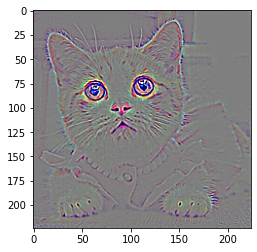

2655

In [34]:
def normalize(I):
    norm = (I-I.mean())/I.std()
    # 把`std`重置为0.1，让梯度尽可能接近0
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm


def plot_Guided_backprop(image_path, model=None):
    img = PIL.Image.open(image_path).convert('RGB')
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    size = 224

    transforms = torchvision.transforms
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    tensor = transform(img).unsqueeze(0).requires_grad_()

    if model is None:
        model = torchvision.models.vgg16(pretrained=True)

    guided_bp = Guided_backprop(model)
    result = guided_bp.visualize(tensor, None)

    result = normalize(result)
    plt.imshow(result)
    plt.show()

plot_Guided_backprop("./_files/cat.jpg")
gc.collect()

Guided Backpropagation的缺点是对target class不敏感，设置不同的target class最终可能得到的gradient map差别不大。基于此，有[Grad-CAM](https://link.zhihu.com/?target=https%3A//arxiv.org/abs/1610.02391)等更高级的可视化方法，其他还有可视化中间特征图等，可以参考[CNN的一些可视化方法](https://zhuanlan.zhihu.com/p/53683453)。